<a href="https://colab.research.google.com/github/cristianmunoz1/DeepLearning-Project/blob/main/02_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocesamiento

Para este caso vamos a realizar operaciones para preparar las imagenes a las capas de entrada de los modelos que se van a plantear. Antes de entrenar los modelos, es necesario preparar las imágenes para que todas tengan un formato uniforme y puedan ser procesadas correctamente.
Operaciones como unificación, redimension, organización por lotes

In [ ]:
!pip install -q kaggle

Subida del token para la extracción de datos desde Kaggle

In [ ]:
from google.colab import files
import os

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhonatangranda","key":"0f547dc8ab8b2e9acb4f8c16c675367c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nikitarom/planets-dataset
!unzip -q planets-dataset.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0
 98% 1.47G/1.50G [00:15<00:00, 242MB/s]
100% 1.50G/1.50G [00:15<00:00, 103MB/s]


## Esquema de carpetas

In [ ]:
import os
print(os.listdir("data"))
print("------------")
print(os.listdir("data/planet/planet"))

['planet', 'test-jpg-additional']
------------
['sample_submission.csv', 'test-jpg', 'train-jpg', 'train_classes.csv']


Importar librerias necesarias y definir rutas del encarpetado

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2


In [ ]:
PROJECT_FOLDER = 'data/planet/planet'
TRAIN_JPG_DIR = os.path.join(PROJECT_FOLDER, 'train-jpg')
TEST_JPG_DIR = os.path.join(PROJECT_FOLDER, 'test-jpg')
TRAIN_CSV_PATH = os.path.join(PROJECT_FOLDER, 'train_classes.csv')

# Tamaño objetivo para las imágenes
IMG_SIZE = (128, 128)  # cambair  a 224x224 si tfl

print(f"Tamaño de imagen objetivo: {IMG_SIZE}")


Tamaño de imagen objetivo: (128, 128)


##Codificación Multi-hot

Queremos cargar las etiquetas em un Dataframe, dado que vienen como texto y pueden haber multiples categorias por imagen. Por tanto necesitamos hacer la codificación, y para ello se descompone la cadena de etiquetas y se crea una columna binaria por clase, generando un vector multi-hot que indica con 1 o 0 si la etiqueta está presente en cada imagen.

In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
# Convertir etiquetas a formato binario (multi-label)
dummies = train_df['tags'].str.get_dummies(' ')
labels = dummies.columns.values
N_LABELS = len(labels)

# Concatenar con el dataframe original
train_df = pd.concat([train_df, dummies], axis=1)

print(f"Total de imágenes: {len(train_df)}")
print(f"Número de clases: {N_LABELS}")
print(f"\nClases:\n{list(labels)}")
train_df.head()

Total de imágenes: 40479
Número de clases: 17

Clases:
['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


##División del dataset

Realizamos el proceso de separación del dataset para dividirlo en dos subconjuntos: uno destinado al entrenamiento del modelo y otro reservado para validación. Esta división permite evaluar el desempeño del modelo con datos que no ha visto durante el aprendizaje, asegurando una medición más realista de su capacidad de generalización.

In [ ]:
# División 80% train, 20% validation
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Resetear índices
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"✓ Datos divididos:")
print(f"  - Entrenamiento: {len(train_data)} imágenes ({len(train_data)/len(train_df)*100:.1f}%)")
print(f"  - Validación: {len(val_data)} imágenes ({len(val_data)/len(train_df)*100:.1f}%)")

✓ Datos divididos:
  - Entrenamiento: 32383 imágenes (80.0%)
  - Validación: 8096 imágenes (20.0%)


Se toma una muestra aleatoria de imágenes y se registra el ancho y alto de cada una con el objetivo de verificar si el dataset presenta tamaños variados o una resolución uniforme. Esta comprobación ayuda a detectar posibles inconsistencias antes del preprocesamiento, ya que trabajar con imágenes de distintas dimensiones requiere redimensionarlas o aplicar transformaciones adicionales

In [ ]:
sample_size = 100
img_sizes = []

for img_name in train_df['image_name'].sample(sample_size, random_state=42):
    img_path = os.path.join(TRAIN_JPG_DIR, f"{img_name}.jpg")
    img = Image.open(img_path)
    img_sizes.append(img.size)

sizes_df = pd.DataFrame(img_sizes, columns=['width', 'height'])
print("\nTamaños encontrados (muestra de 100):")
print(sizes_df.value_counts())

unique_sizes = sizes_df.drop_duplicates()
if len(unique_sizes) == 1:
    print(f"\n Todas las imágenes tienen el mismo tamaño: {unique_sizes.iloc[0]['width']}x{unique_sizes.iloc[0]['height']}")



Tamaños encontrados (muestra de 100):
width  height
256    256       100
Name: count, dtype: int64

 Todas las imágenes tienen el mismo tamaño: 256x256


Se define una función encargada de preparar las imágenes antes de ingresarlas al modelo. Primero, se localiza y carga la imagen correspondiente a su nombre de archivo. Luego, se redimensiona a un tamaño fijo. Después, la imagen se convierte a un arreglo numérico y se normalizan los valores de sus píxeles al rango [0, 1], lo que estabiliza el entrenamiento y mejora la convergencia del modelo. Finalmente, se prueba la función con una imagen para confirmar que el tamaño, el tipo de dato y el rango numérico son los esperados

In [ ]:
def load_and_preprocess_image(img_name, img_size=IMG_SIZE):
    """
    Carga una imagen, la redimensiona y normaliza.

    Parámetros:
    - img_name: nombre del archivo sin extensión
    - img_size: tupla (width, height) del tamaño deseado

    Retorna:
    - Array numpy normalizado de shape (height, width, 3)
    """
    img_path = os.path.join(TRAIN_JPG_DIR, f"{img_name}.jpg")
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar a rango [0, 1]
    return img_array

# Probar con una imagen
sample_img_name = train_df['image_name'].iloc[16]
sample_img = load_and_preprocess_image(sample_img_name)

print(f" Shape: {sample_img.shape}")
print(f" Rango de valores: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
print(f" Tipo de dato: {sample_img.dtype}")


 Shape: (128, 128, 3)
 Rango de valores: [0.051, 0.322]
 Tipo de dato: float32


Para ilustrar el efecto del preprocesamiento, se muestra una comparación entre una imagen original del dataset y su versión transformada. A la izquierda aparece la imagen tal como fue capturada, con su tamaño y formato original. A la derecha se visualiza la misma imagen después del preprocesamiento, donde ya ha sido redimensionada y normalizada para ajustarse a los requerimientos del modelo.

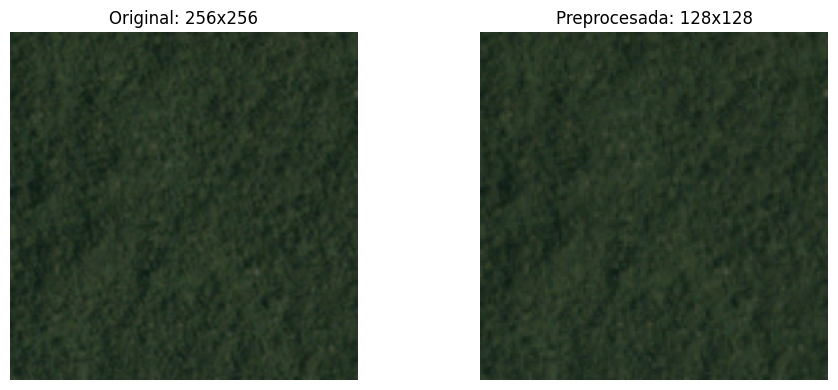

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Imagen original
img_path = os.path.join(TRAIN_JPG_DIR, f"{sample_img_name}.jpg")
img_original = Image.open(img_path)
axes[0].imshow(img_original)
axes[0].set_title(f"Original: {img_original.size[0]}x{img_original.size[1]}")
axes[0].axis('off')

# Imagen preprocesada
axes[1].imshow(sample_img)
axes[1].set_title(f"Preprocesada: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Data generator

El entrenamiento del modelo requiere que las imágenes no se carguen todas a la vez, sino en pequeños grupos para ahorrar memoria y acelerar el proceso. Para esto se utiliza un generador de datos, el cual se encarga de leer las imágenes desde el disco, aplicarles el preprocesamiento definido y agruparlas en lotes junto con sus etiquetas correspondientes.

En cada iteración, el generador selecciona un conjunto de imágenes, las transforma al tamaño requerido por el modelo y convierte sus etiquetas en un formato binario adecuado para la clasificación multietiqueta. Además, puede mezclar el orden de los datos en cada época, ayudando a evitar que el modelo se acostumbre a un patrón fijo y mejorando su capacidad de generalización.

In [ ]:
def data_generator(dataframe, batch_size=32, img_size=IMG_SIZE, shuffle=True):
    """
    Generador que carga imágenes en lotes (batches).

    Parámetros:
    - dataframe: DataFrame con columnas 'image_name' y etiquetas
    - batch_size: número de imágenes por lote
    - img_size: tamaño objetivo de las imágenes
    - shuffle: si mezclar los datos en cada época

    Yields:
    - (batch_images, batch_labels): tupla con arrays numpy
    """
    n_samples = len(dataframe)
    indices = np.arange(n_samples)

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                row = dataframe.iloc[idx]

                # Cargar y preprocesar imagen
                img = load_and_preprocess_image(row['image_name'], img_size)

                # Obtener etiquetas en formato binario
                label = row[labels].values.astype('float32')

                batch_images.append(img)
                batch_labels.append(label)

            yield np.array(batch_images), np.array(batch_labels)

Ejemplo de prueba

In [ ]:
# Crear generador de prueba
test_gen = data_generator(train_data, batch_size=4, shuffle=False)

# Obtener un batch
X_batch, y_batch = next(test_gen)

print(f"  Shape de imágenes: {X_batch.shape}")
print(f"  Shape de etiquetas: {y_batch.shape}")
print(f"  Tipo de dato imágenes: {X_batch.dtype}")
print(f"  Tipo de dato etiquetas: {y_batch.dtype}")
print(f"\nEjemplo de vector de etiquetas del primer item:")
print(y_batch[0])
print(f"\nEtiquetas activas: {[labels[i] for i, val in enumerate(y_batch[0]) if val == 1]}")



  Shape de imágenes: (4, 128, 128, 3)
  Shape de etiquetas: (4, 17)
  Tipo de dato imágenes: float32
  Tipo de dato etiquetas: float32

Ejemplo de vector de etiquetas del primer item:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]

Etiquetas activas: ['clear', 'primary', 'water']


Tomar un lote de 6 imagenes y aplicar el preprocesamiento y la visualización de la imagen

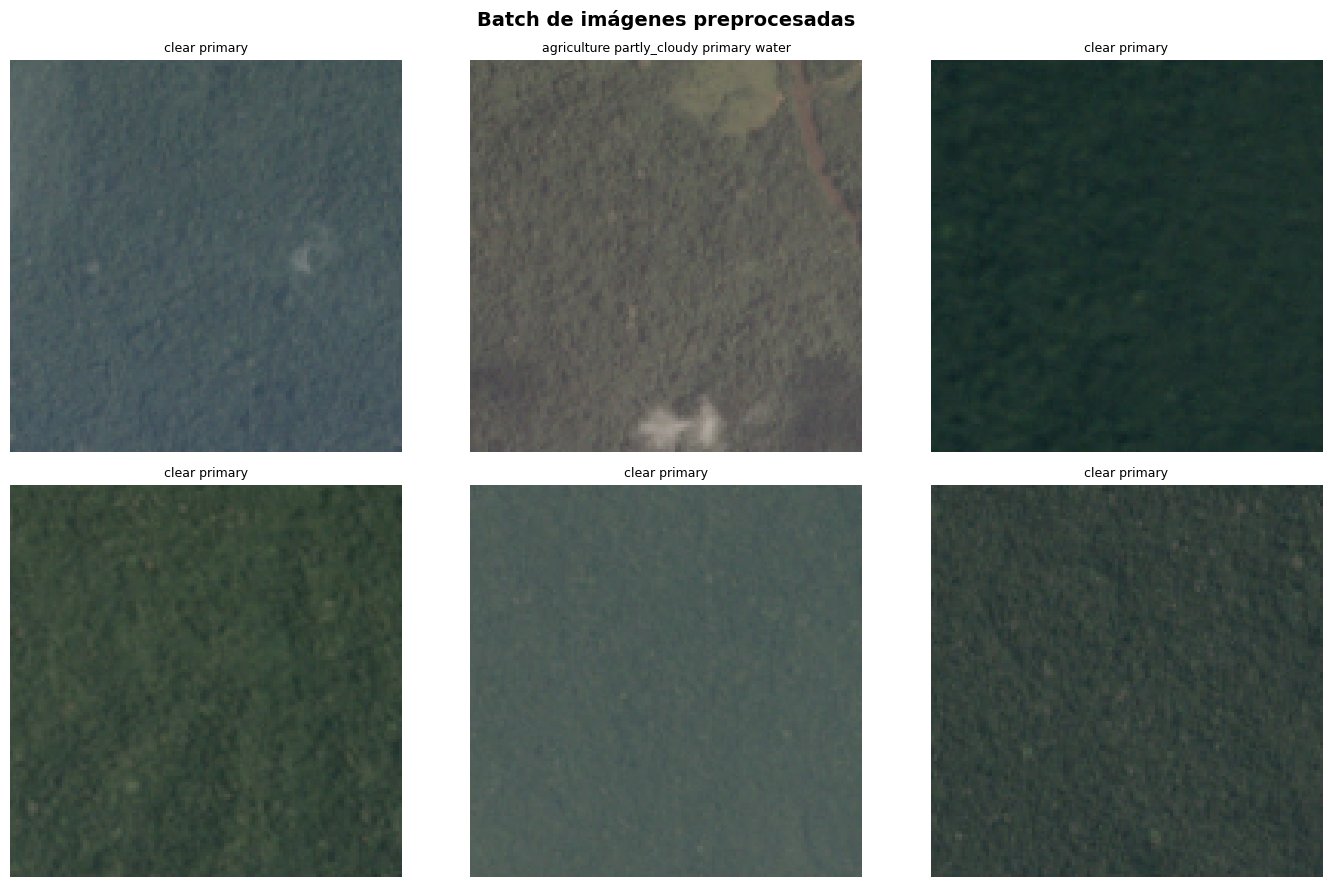

In [ ]:
# Crear generador y tomar un batch
vis_gen = data_generator(train_data, batch_size=6, shuffle=True)
X_vis, y_vis = next(vis_gen)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Batch de imágenes preprocesadas', fontsize=14, fontweight='bold')

for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.imshow(X_vis[i])
    ax.axis('off')

    # Mostrar etiquetas activas
    active_labels = [labels[j] for j, val in enumerate(y_vis[i]) if val == 1]
    ax.set_title(' '.join(active_labels), fontsize=9, wrap=True)

plt.tight_layout()
plt.show()


Consideraciones generales

In [ ]:
BATCH_SIZE = 32  # Tamaño de batch recomendado para empezar

steps_per_epoch_train = len(train_data) // BATCH_SIZE
steps_per_epoch_val = len(val_data) // BATCH_SIZE

print(f"CONFIGURACIÓN PARA ENTRENAMIENTO")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps por época (train): {steps_per_epoch_train}")
print(f"Steps por época (val): {steps_per_epoch_val}")
print(f"Imágenes por época (train): {steps_per_epoch_train * BATCH_SIZE}")
print(f"Imágenes por época (val): {steps_per_epoch_val * BATCH_SIZE}")

CONFIGURACIÓN PARA ENTRENAMIENTO
Batch size: 32
Steps por época (train): 1011
Steps por época (val): 253
Imágenes por época (train): 32352
Imágenes por época (val): 8096


Entonces se considera que para el sigyiente otebook, probando una arquitectura base podemos usar generadores para el proceso de entrenamiento

In [ ]:
train_generator = data_generator(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_generator = data_generator(val_data, batch_size=BATCH_SIZE, shuffle=False)

print("  train_generator")
print("  val_generator")
print("  steps_per_epoch_train")
print("  steps_per_epoch_val")
print("  N_LABELS (número de clases de salida)")

  train_generator
  val_generator
  steps_per_epoch_train
  steps_per_epoch_val
  N_LABELS (número de clases de salida)


In [ ]:

print(f"RESUMEN DEL PREPROCESAMIENTO")
print(f"Datos cargados: {len(train_df)} imágenes totales")
print(f"División train/val: {len(train_data)}/{len(val_data)}")
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Número de clases: {N_LABELS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalización: [0, 1]")
print(f"Formato de etiquetas: Multi-label binario")


RESUMEN DEL PREPROCESAMIENTO
Datos cargados: 40479 imágenes totales
División train/val: 32383/8096
Tamaño de imagen: (128, 128)
Número de clases: 17
Batch size: 32
Normalización: [0, 1]
Formato de etiquetas: Multi-label binario
